In [1]:
%load_ext autoreload
%autoreload 2


# Problem Inputs

In [2]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from openap import prop

# -------------------------
# 0. Load aircraft and engine data
# -------------------------
fiche_ac = prop.aircraft("A320")
fiche_engine = prop.engine("CFM56-5-A1")
# Ensure all engine parameters are valid
for key in fiche_engine:
    if isinstance(fiche_engine[key], (int, float)):
        if np.isnan(fiche_engine[key]) or fiche_engine[key] <= 0:
            print(f"Warning: Invalid engine parameter: {key}")
print('Check these warnings carefully since they may cause NaNs in the optimization.')

fiche_engine['cruise_sfc'] = 16.9 / 1000 # kg/(N.s), from Wikipedia 

fiche_control = {
    'k_gamma': 0.45  # P controller gain for flight path angle
}

# Problem Inputs ----------
FL_CRZ = 37000
S_MAX = 684 * 1852
# -------------------------

# 1. Conversion factors and target values
# -------------------------
knots_to_ms = 0.514444
ft_to_m     = 0.3048

# Speeds (m/s)
v_250    = 250 * knots_to_ms       # ~128.61 m/s
v_300    = 300 * knots_to_ms       # ~154.33 m/s
v_mach78 = 0.78 * 340              # ~265.2 m/s (approx.)
v_180    = 180 * knots_to_ms 


# Altitudes (m)
h_takeoff_end  = 1000  * ft_to_m    # 1,000 ft
h_climb1_end   = 10000 * ft_to_m    # 10,000 ft (~3048 m)
h_climb2_end   = FL_CRZ * ft_to_m    # 35,000 ft (~10668 m) transition altitude
h_cruise       = FL_CRZ * ft_to_m    # 35,000 ft (~10668 m)
h_descent1_end = 10000 * ft_to_m    # 10,000 ft (~3048 m)
h_descent2_end = 3000 * ft_to_m    # 3,000 ft (~914.4 m)
h_landing_end  = 0.0               # ground




Check these warnings carefully since they may cause NaNs in the optimization.


# Aircraft Dynamics

In [3]:
# -------------------------
# 2. Define the aircraft dynamics function (same as before)
# -------------------------
def aircraft_dynamics(x, u, wind_s, phi, phase, fiche_engine, fiche_ac, fiche_control, num_engines = 2):
    """
    Computes the state derivative for the vertical dynamics.
    x = [v, gamma, h, s, m] # speed, flight path angle, altitude, along-path distance, mass
    u = [T, gamma_ref, beta] # thrust, reference flight path angle, speedbrake parameter
    """
    g = 9.81  # gravitational acceleration (m/s^2)

    # Unpack control parameters
    k_gamma = fiche_control['k_gamma']
    
    # Unpack state and control
    v, gamma, h, s, m = x[0], x[1], x[2], x[3], x[4]  # speed, flight path angle, altitude, along-path distance, mass
    T, gamma_ref, beta = u[0], u[1], u[2]  # thrust, controlled flight path angle, speedbrake parameter
    
    # --- Drag Model ---
    rho0 = 1.225  # sea-level density [kg/m^3]
    H    = 8500.0 # scale height [m]
    rho  = rho0 * ca.exp(-h/H) # air density [kg/m^3]

    # --- Load factor calculation ---
    nz = (-v * k_gamma * (gamma - gamma_ref) + g * ca.cos(gamma))/(g * ca.cos(phi))

    # --- Lift/Drag Calculations ---
    L = nz * m * g  # Required lift force
    epsilon = 1e-6  # small number to avoid division by zero
    v_sq = v**2 + epsilon

    S_area = fiche_ac['wing']['area']  # wing area [m^2]
    Cl = L / (0.5 * rho * v_sq * S_area)
    
    k = fiche_ac['drag']['k']
    Cd = fiche_ac['drag']['cd0'] + beta + k * Cl**2  # parabolic drag model
    D = 0.5 * rho * v**2 * S_area * Cd  # Drag force [N]

    # Fuel flow model (different for each phase)
    if phase in ['cruise', 'descent1', 'descent2', 'landing']:
        cruise_sfc = fiche_engine['cruise_sfc'] / 3600.0  # [kg/(N·s)]
        fuel_coef = fiche_ac['fuel']['fuel_coef']
        fuel_flow = fuel_coef * cruise_sfc * T
    elif phase == 'takeoff':
        fuel_flow = fiche_engine['ff_to'] * num_engines
    elif phase in ['climb1', 'climb2', 'climb3']:
        fuel_flow = fiche_engine['ff_co'] * num_engines
    # elif phase in ['descent1', 'descent2']:
    #     fuel_flow = fiche_engine['ff_app'] * num_engines
    # elif phase == 'landing':
    #     fuel_flow = fiche_engine['ff_idl'] * num_engines
    
    # Dynamics equations
    v_dot     = (T - D) / m - g * ca.sin(gamma)
    gamma_dot = k_gamma * (gamma_ref - gamma)
    h_dot     = v * ca.sin(gamma)
    s_dot     = v * ca.cos(gamma) + wind_s
    m_dot     = -fuel_flow
    
    return ca.vertcat(v_dot, gamma_dot, h_dot, s_dot, m_dot)



# Phases

In [4]:
# -------------------------
# 3. Phase definitions
# -------------------------
# We define three phases:
#   - climb1: from 0 ft to 10,000 ft, target speed 250 kts.
#   - climb2: from 10,000 ft to 18,000 ft, target speed 300 kts.
#   - cruise: from 18,000 ft to 35,000 ft, target speed Mach 0.78.

h_takeoff_end  = 1000  * ft_to_m    # 1,000 ft
h_climb1_end   = 10000 * ft_to_m    # 10,000 ft (~3048 m)
h_climb2_end   = FL_CRZ * ft_to_m    # 35,000 ft (~10668 m) transition altitude
h_cruise       = FL_CRZ * ft_to_m    # 35,000 ft (~10668 m)
h_descent1_end = 10000 * ft_to_m    # 10,000 ft (~3048 m)
h_descent2_end = 3000 * ft_to_m    # 3,000 ft (~914.4 m)
h_landing_end  = 0.0               # ground

phases = [
    {"name": "climb1", "N": 50, "h0": 0.0,          "hF": h_climb1_end,  "v_target": v_250},
    {"name": "climb2", "N": 50, "h0": h_climb1_end,  "hF": h_climb2_end,  "v_target": v_300},
    {"name": "cruise", "N": 100, "h0": h_climb2_end,  "hF": h_cruise,      "v_target": v_mach78},
    {"name": "descent1", "N": 100, "h0": h_cruise, "hF": h_descent1_end, "v_target": v_300},
    {"name": "descent2", "N": 50, "h0": h_descent1_end, "hF": h_descent2_end, "v_target": v_250},
    {"name": "landing", "N": 50, "h0": h_descent2_end, "hF": h_landing_end, "v_target": v_180}
]

In [5]:

# -------------------------
# 4. Set up the Opti problem and common parameters
# -------------------------
opti = ca.Opti()

wind_s = opti.parameter();  opti.set_value(wind_s, 0.0)
phi    = opti.parameter();  opti.set_value(phi, 0.0)
CI     = opti.parameter();  opti.set_value(CI, 100.0)

X_list = []  # states for each phase
U_list = []  # controls for each phase
T_list = []  # phase durations
N_list = []  # discretization intervals
phase_names = []


# Altitude, Speed Boundaries, Phase Time and State Limits

In [6]:
# -------------------------
# 5. Create decision variables for each phase
# -------------------------

# Slack variables for soft constraints about speed and altitude
V_slacks = []
H_slacks = []

for i, phase in enumerate(phases):
    name = phase["name"]
    phase_names.append(name)
    N_phase = phase["N"]
    N_list.append(N_phase)
    
    T_phase = opti.variable()
    opti.subject_to(T_phase >= 0)
    T_list.append(T_phase)
    if name == 'climb1':
        opti.set_initial(T_phase, 10_000 / (3000 / 60)) # climb at 3000 ft/mi
    elif name == 'climb2':
        opti.set_initial(T_phase, (FL_CRZ - 10_000) / (3000 / 60)) # climb at 3000 ft/min
    elif name == 'descent1':
        opti.set_initial(T_phase, (FL_CRZ - 10_000) / (1500 / 60)) # descent at 1500 ft/min
        opti.subject_to(T_phase < 1.3 * (FL_CRZ - 10_000) / (1500 / 60))
    elif name == 'descent2':
        opti.set_initial(T_phase, 7_000 / (1500 / 60)) # descent at 1500 ft/min
        opti.subject_to(T_phase < 1.3 * 7_000 / (1500 / 60))
    elif name == "landing":
        opti.set_initial(T_phase, 3_000 / (1500 / 60))
        opti.subject_to(T_phase < 1.3 * 3_000 / (1500 / 60))
    elif name == "cruise":
        opti.set_initial(T_phase, 0.7 * S_MAX / v_250)
        opti.subject_to(T_phase >= 0.5 * S_MAX / v_250)
    # if name == "descent1":
    #     opti.set_initial(T_phase, 0.15 * S_MAX / v_250)
    #     opti.subject_to(T_phase >= 0.05 * S_MAX / v_250)
    # if name == "descent2":
    #     opti.set_initial(T_phase, 0.1 * S_MAX / v_250)
    #     opti.subject_to(T_phase >= 0.05 * S_MAX / v_250)
    dt = T_phase / N_phase  # time step
    
    # State vector: [v, gamma, h, s, m] over (N_phase+1) nodes
    X = opti.variable(5, N_phase+1) # N_phase+1 time steps
    # Control vector: [T, gamma_ref, beta] over N_phase intervals
    U = opti.variable(3, N_phase)
    
    X_list.append(X)
    U_list.append(U)
    
    # Multiple shooting dynamics via explicit Euler integration
    for k in range(N_phase): # between N_phase + 1 time steps are N_phase intervals
        xk = X[:, k]
        uk = U[:, k]
        x_next = X[:, k+1]
        x_next_euler = xk + dt * aircraft_dynamics(xk, uk, wind_s, phi, name, fiche_engine, fiche_ac, fiche_control)
        opti.subject_to(x_next == x_next_euler)
    
    # Altitude boundary conditions for each phase (altitude at the beginning and end of each phase)
    # Soft constraints for initial and final altitude with slack variables
    h_slack_init = opti.variable()
    h_slack_final = opti.variable()
    opti.set_initial(h_slack_init, 0)
    opti.set_initial(h_slack_final, 0)
    
    max_alt_dev = 100.0  # Allow ±50m deviation
    opti.subject_to(h_slack_init <= max_alt_dev)
    opti.subject_to(h_slack_init >= -max_alt_dev)
    opti.subject_to(h_slack_final <= max_alt_dev) 
    opti.subject_to(h_slack_final >= -max_alt_dev)
    
    opti.subject_to(X[2, 0] == phase["h0"] + h_slack_init)
    opti.subject_to(X[2, -1] == phase["hF"] + h_slack_final)
    
    # Enforce prescribed speed if provided
    # if phase["v_target"] is not None:
    #     for k in range(N_phase+1):
    #         opti.subject_to(X[0, k] == phase["v_target"])
    
    # Soft constraints on prescribed speed and altitude
    V_slack = opti.variable(N_phase + 1)
    H_slack = opti.variable(N_phase + 1)
    opti.set_initial(V_slack, 0) # set initial guess for slack variables
    if phase["v_target"] is not None:
        max_speed_dev = 10.0  # Allow ±20 m/s deviation
        
        if phase['name'] == 'climb1':
            for k in range(N_phase + 1):
                opti.subject_to(V_slack[k] <= max_speed_dev)
                opti.subject_to(V_slack[k] >= -max_speed_dev)
                opti.subject_to(X[0, k] == phase["v_target"] + V_slack[k])

        elif phase['name'] == 'climb2':
            last_phase = phases[i-1]
            for k in range(5): # first 5 timesteps, accelerating from last phase's speed
                if k == 0:
                    opti.subject_to(V_slack[k] > 0)
                else:
                    opti.subject_to(V_slack[k] > V_slack[k-1])
                opti.subject_to(V_slack[k] <= phase["v_target"] - last_phase["v_target"])
                opti.subject_to(X[0, k] == last_phase["v_target"] + V_slack[k])
            for k in range(5, N_phase + 1): # middle timesteps
                opti.subject_to(V_slack[k] <= max_speed_dev)
                opti.subject_to(V_slack[k] >= -max_speed_dev)
                opti.subject_to(X[0, k] == phase["v_target"] + V_slack[k])

        elif phase['name'] == 'cruise':
            last_phase = phases[i-1]
            for k in range(5): # first 5 timesteps, accelerating from last phase's speed
                if k == 0:
                    opti.subject_to(V_slack[k] > 0)
                else:
                    opti.subject_to(V_slack[k] > V_slack[k-1])
                    opti.subject_to(V_slack[k] <= phase["v_target"] - last_phase["v_target"])
                opti.subject_to(X[0, k] == last_phase["v_target"] + V_slack[k])
            for k in range(5, N_phase + 1): # middle timesteps
                opti.subject_to(V_slack[k] <= max_speed_dev)
                opti.subject_to(V_slack[k] >= -max_speed_dev)
                opti.subject_to(X[0, k] == phase["v_target"] + V_slack[k])

        elif phase['name'] in ['descent1', 'descent2', 'landing']:
            last_phase = phases[i-1]
            for k in range(10): # first 5 timesteps, decelerating from last phase's speed
                if k == 0:
                    opti.subject_to(V_slack[k] < 0)
                else:
                    opti.subject_to(V_slack[k] < V_slack[k-1])
                opti.subject_to(V_slack[k] >= phase["v_target"] - last_phase["v_target"])
                opti.subject_to(X[0, k] == last_phase["v_target"] + V_slack[k])
            for k in range(10, N_phase + 1): # middle timesteps
                opti.subject_to(V_slack[k] <= max_speed_dev)
                opti.subject_to(V_slack[k] >= -max_speed_dev)
                opti.subject_to(X[0, k] == phase["v_target"] + V_slack[k])

        else:
            for k in range(N_phase + 1):
                opti.subject_to(V_slack[k] <= max_speed_dev)
            opti.subject_to(V_slack[k] >= -max_speed_dev)
            opti.subject_to(X[0, k] == phase["v_target"] + V_slack[k])
    else:
        # For phases without a prescribed speed, enforce zero slack.
        for k in range(N_phase + 1):
            opti.subject_to(V_slack[k] == 0)
    V_slacks.append(V_slack)
    
    # For cruise phase, enforce constant altitude along the entire phase
    # if name == "cruise":
    #     for k in range(N_phase + 1):
    #         opti.subject_to(X[2, k] == h_cruise)
    
    # For cruise phase, use soft constraints for altitude
    H_slack = opti.variable(N_phase + 1)
    opti.set_initial(H_slack, 0) # set initial guess for slack variables
    if name == "cruise":
        max_alt_dev = 100.0  # Allow ±100 m deviation
        for k in range(N_phase + 1):
            opti.subject_to(H_slack[k] <= max_alt_dev)
            opti.subject_to(H_slack[k] >= -max_alt_dev)
            opti.subject_to(X[2, k] == h_cruise + H_slack[k])
    elif name in ['descent1', 'descent2', 'landing']:
        last_phase = phases[i-1]
        last_phase_alt = last_phase.get("hF")
        current_phase_alt = phase.get("hF")
        
        max_alt_dev = 100.0  # Allow ±100 m deviation
        for k in range(N_phase + 1):
            # Linear interpolation between altitudes
            target_alt = last_phase_alt + (current_phase_alt - last_phase_alt) * (k / N_phase)
            
            opti.subject_to(H_slack[k] <= max_alt_dev)
            opti.subject_to(H_slack[k] >= -max_alt_dev)
            opti.subject_to(X[2, k] == target_alt + H_slack[k])
    else:
        # For phases other than cruise, enforce zero slack.
        for k in range(N_phase + 1):
            opti.subject_to(H_slack[k] == 0)
    H_slacks.append(H_slack)


    # Additional state bounds (applied at every node)
    for k in range(N_phase+1):
        opti.subject_to(X[0, k] >= 0)        # v lower bound
        opti.subject_to(X[0, k] <= 350)      # v upper bound
        opti.subject_to(X[1, k] >= -0.5)       # gamma lower bound
        opti.subject_to(X[1, k] <= 0.5)        # gamma upper bound
        opti.subject_to(X[2, k] >= 0)          # altitude lower bound
        opti.subject_to(X[2, k] <= 12000)      # altitude upper bound (sufficient for cruise)
        opti.subject_to(X[3, k] >= 0)          # along-path distance lower bound
        opti.subject_to(X[4, k] >= 30000)      # mass lower bound
        opti.subject_to(X[4, k] <= 90000)      # mass upper bound
    
    # Control bounds for each interval
    for k in range(N_phase):
        opti.subject_to(U[0, k] >= 0.1 * fiche_engine['max_thrust'])        # Thrust lower bound
        opti.subject_to(U[0, k] <= fiche_engine['max_thrust'])   # Thrust upper bound
        opti.subject_to(U[1, k] >= -0.5)       # gamma_ref lower bound
        opti.subject_to(U[1, k] <= 0.5)        # gamma_ref upper bound
        opti.subject_to(U[2, k] >= 0.0)        # beta lower bound
        opti.subject_to(U[2, k] <= 0.02)        # beta upper bound



# Phase Continuity

In [7]:
# -------------------------
# 6. Impose continuity between phases
# -------------------------
# Ensure that the final state of phase i equals the initial state of phase i+1.
for i in range(len(phases)-1):
    opti.subject_to(X_list[i+1][:, 0] == X_list[i][:, -1]) # skip velocity mismatch

# Initial and Final Conditions

In [8]:
# -------------------------
# 7. Impose boundary conditions on the first phase (takeoff/climb1)
# -------------------------
# Initial state: [v, gamma, h, s, m]
x0 = np.array([v_250, 0.0, 0.0, 0.0, 70000.0])
opti.set_initial(X_list[0][:, 0], x0)
opti.subject_to(X_list[0][3, 0] == 0.0)   # along-path distance

# Until traveled distance s is 200_000m - only constrain final point
# opti.subject_to(X_list[-1][3, -1] == 200_000)

# At final descent, the traveled distance (soft constraint)
S_slack = opti.variable()  # Slack variable for distance constraint
opti.subject_to(S_slack >= 0)  # Slack must be non-negative
opti.subject_to(X_list[-1][3, -1] + S_slack >= S_MAX)  # Soft constraint with slack

# For climb1, ensure the final speed is the prescribed v_250
# opti.subject_to(X_list[0][0, -1] == v_250)


# Cost Function

In [9]:
# -------------------------
# 8. Define the overall cost function
# -------------------------
# Here, the cost in each phase is integrated over time.
total_cost = 0
for i, phase in enumerate(phases):
    N_phase = phase["N"]
    T_phase = T_list[i]
    dt = T_phase / N_phase
    X = X_list[i]
    U = U_list[i]
    J_phase = 0
    alt_h0_hf_weight = 1e3
    speed_penalty_weight = 1e3
    alt_penalty_weight = 1e3
    distance_penalty_weight = 1e4
    control_smoothing_weight = [1e-5, 1e-3, 1e-3] # [T, gamma_ref, beta]
            
    for k in range(N_phase):
        T_k = U[0, k]
        # Example: simple cost (you can replace fuel_flow model as needed)
        # fuel_flow_k = 0.0001 * T_k  # [kg/s]
        # J_phase += (fuel_flow_k + CI) * dt
        J_phase += (CI) * dt
        speed_penalty = speed_penalty_weight * V_slacks[i][k]**2
        alt_penalty = alt_penalty_weight * H_slacks[i][k]**2
        J_phase += speed_penalty + alt_penalty

    alt_h0_hf_penalty = alt_h0_hf_weight * (h_slack_init**2 + h_slack_final**2)
    J_phase += alt_h0_hf_penalty
    J_phase += distance_penalty_weight * S_slack**2

    # --------------------------------
    # CONTROL-RATE PENALTY
    # --------------------------------
    # We add a loop from k=1..N_phase-1 to penalize changes in U
    for k in range(1, N_phase):
        # Sums of squares of changes in [T, gamma_ref, beta]
        J_phase += ca.sumsqr(control_smoothing_weight * (U[:, k] - U[:, k-1]))
    # --------------------------------
    total_cost += J_phase
    
opti.minimize(total_cost)



# Initial Guesses

In [10]:
# -------------------------
# 9. Provide initial guesses for states and controls
# -------------------------
for i, phase in enumerate(phases):
    N_phase = phase["N"]
    X = X_list[i]
    for k in range(N_phase+1):
        # Linear interpolation for altitude between phase boundaries
        h_guess = phase["h0"] + (phase["hF"] - phase["h0"]) * k / N_phase
        opti.set_initial(X[2, k], h_guess)
        
        # For speed, if v_target is enforced, it is already fixed.
        if phase["v_target"] is not None:
            if phase["name"] == "takeoff":
                v_guess = 0 + (v_250 - 0) * k / N_phase
                opti.set_initial(X[0, k], v_guess) # set initial guess, not initial condition
            elif phase["name"] == "climb1":
                opti.set_initial(X[0, k], v_250)
            elif phase["name"] == "climb2":
                last_phase_speed = v_250  # Speed from climb1
                target_speed = v_300
                if k <= N_phase/2:
                    # Linear interpolation for first half
                    v_guess = last_phase_speed + (target_speed - last_phase_speed) * (k/(N_phase/2))
                else:
                    # Constant speed for second half
                    v_guess = target_speed
                opti.set_initial(X[0, k], v_guess)
            elif phase["name"] == "cruise":
                last_phase_speed = v_300  # Speed from climb2
                target_speed = v_mach78
                if k <= N_phase/2:
                    v_guess = last_phase_speed + (target_speed - last_phase_speed) * (k/(N_phase/2))
                else:
                    v_guess = target_speed
                opti.set_initial(X[0, k], v_guess)
            elif phase["name"] == "descent1":
                last_phase_speed = v_mach78  # Speed from cruise
                target_speed = v_300
                if k <= N_phase/2:
                    v_guess = last_phase_speed + (target_speed - last_phase_speed) * (k/(N_phase/2))
                else:
                    v_guess = target_speed
                opti.set_initial(X[0, k], v_guess)
            elif phase["name"] == "descent2":
                last_phase_speed = v_300  # Speed from descent1
                target_speed = v_250
                if k <= N_phase/2:
                    v_guess = last_phase_speed + (target_speed - last_phase_speed) * (k/(N_phase/2))
                else:
                    v_guess = target_speed
                opti.set_initial(X[0, k], v_guess)
            elif phase["name"] == "landing":
                last_phase_speed = v_250  # Speed from descent2
                target_speed = v_180
                if k <= N_phase/2:
                    v_guess = last_phase_speed + (target_speed - last_phase_speed) * (k/(N_phase/2))
                else:
                    v_guess = target_speed
                opti.set_initial(X[0, k], v_guess)
        else:
            opti.set_initial(X[0, k], v_250) # other phases without v_target prescribed
        # Provide guesses for other states.
        opti.set_initial(X[1, k], 0.0)  # gamma
        opti.set_initial(X[4, k], 70000.0 - 1000*i)  # mass

# Along-path distance initial guesses
for i, phase in enumerate(phases):
    N_phase = phase["N"]
    X = X_list[i]
    for k in range(N_phase+1):
        if phase["name"] == "climb1":
            opti.set_initial(X[3, k], 0.0 + 0.05 * S_MAX * (k/float(N_phase)))  # along-path distance
        elif phase["name"] == "climb2":
            opti.set_initial(X[3, k], 0.05 * S_MAX + 0.05 * S_MAX *(k/float(N_phase)))  # along-path distance
        elif phase["name"] == "cruise":
            opti.set_initial(X[3, k], 0.1 * S_MAX + 0.8 * S_MAX *(k/float(N_phase)))  # along-path distance
        elif phase["name"] == "descent1":
            opti.set_initial(X[3, k], 0.9 * S_MAX + 0.04 * S_MAX *(k/float(N_phase)))  # along-path distance
        elif phase["name"] == "descent2":
            opti.set_initial(X[3, k], 0.94 * S_MAX + 0.03 * S_MAX *(k/float(N_phase)))  # along-path distance
        elif phase["name"] == "landing":
            opti.set_initial(X[3, k], 0.97 * S_MAX + 0.03 * S_MAX *(k/float(N_phase)))  # along-path distance
    
    # Initial guesses for controls.
    U = U_list[i]
    for k in range(N_phase):
        opti.set_initial(U[0, k], 50000.0)  # thrust
        opti.set_initial(U[1, k], 0.0)       # gamma_ref
        opti.set_initial(U[2, k], 0.0)       # beta



# Solve

In [11]:
# -------------------------
# 10. Solve the NLP
# -------------------------
p_opts = {"expand": True}
s_opts = {"max_iter": 50e3, "print_level": 5, "tol":1e-6, "acceptable_tol":1e-4}
opti.solver('ipopt', p_opts, s_opts)

try:
    sol = opti.solve()  # Solve the optimization problem
except RuntimeError as e:
    print("Solver error:", e)
    
    # Inspect values at the point where the error occurred
    print("\n--- Debugging Information ---")
    for i, phase in enumerate(phases):
        # print(f"\nPhase: {phase['name']}")
        X_debug = opti.debug.value(X_list[i])
        U_debug = opti.debug.value(U_list[i])
        T_debug = opti.debug.value(T_list[i])

        # print("  States (X) [v, fpa, h, s, m]:")
        # print(X_debug)
        # print("  Controls (U) [thrust, fpa, spdbrk]:")
        # print(U_debug)
        print(f"Phase {phase['name']}, Duration {T_debug}")

        # if "Infeasible_Problem_Detected" in str(e):
            # print("Solver detected infeasibility. Analyzing...")
            # opti.debug.show_infeasibilities()  # Show summary


        # Plot the states
        from state_plot import plot_states, plot_states_ext
        plot_states(X_debug[0], X_debug[1], X_debug[2], X_debug[3], X_debug[4], U_debug[0], U_debug[1], U_debug[2])

        X_ext = np.empty((6, phase['N']))

        # Compute the additional variables
        for k in range(phase['N']):
            xk = X_debug[:,k]
            uk = U_debug[:,k]
            dyn_func = aircraft_dynamics(xk, uk, opti.debug.value(wind_s), opti.debug.value(phi), phase['name'], fiche_engine, fiche_ac, fiche_control)
            dyn_values = opti.debug.value(dyn_func)

            #Further break down
            g = 9.81
            k_gamma = fiche_control['k_gamma']
            v, gamma, h, s, m = xk[0], xk[1], xk[2], xk[3], xk[4]
            T, gamma_ref, beta = uk[0], uk[1], uk[2]
            rho0 = 1.225
            H = 8500.0
            rho = rho0 * np.exp(-h / H)  # Use numpy for scalar calculations during debugging
            nz = (-v * k_gamma * (gamma - gamma_ref) + g * np.cos(gamma))/(g * np.cos(0))
            L = nz * m * g
            epsilon = 1e-6
            v_sq = v**2 + epsilon
            S_area = fiche_ac['wing']['area']
            Cl = L / (0.5 * rho * v_sq * S_area)
            k_drag = fiche_ac['drag']['k']
            Cd = fiche_ac['drag']['cd0'] + beta + k_drag * Cl**2
            D = 0.5 * rho * v**2 * S_area * Cd

            X_ext[:,k] = np.array([L, D, nz, Cl, Cd, rho])
            if np.isnan(X_ext[:,k]).any():
                print(f"NaN detected at index {k}")
                print(f"X_ext[:,k]: {X_ext[:,k]}")
                print(f"X_ext: {X_ext}")
                print(f"X_ext[0]: {X_ext[0]}")
                print(f"X_ext[1]: {X_ext[1]}")
            
            # Check the constraints manually
        # Manually check constraints
        print("\nChecking constraints for phase:", phase['name'])
        
        # Check altitude constraints
        h_min = phase['h0']
        h_max = phase['hF'] 
        h_violations = np.where((X_debug[2,:-1] < h_min) | (X_debug[2,:-1] > h_max))[0]
        if len(h_violations) > 0:
            print(f"Altitude constraint violations at steps: {h_violations}")
            print(f"Values: {X_debug[2,h_violations]}")
            print(f"Bounds: [{h_min}, {h_max}]")
            
        # Check speed constraints
        v_target = phase['v_target']
        v_tolerance = 10.0  # m/s tolerance
        v_violations = np.where(abs(X_debug[0,:-1] - v_target) > v_tolerance)[0]
        if len(v_violations) > 0:
            print(f"Speed constraint violations at steps: {v_violations}")
            print(f"Values: {X_debug[0,v_violations]}")
            print(f"Target: {v_target} ± {v_tolerance}")
            
        # Check load factor constraints
        nz_max = 1.3  # maximum load factor
        nz_violations = np.where(abs(X_ext[2,:]) > nz_max)[0]
        if len(nz_violations) > 0:
            print(f"Load factor constraint violations at steps: {nz_violations}")
            print(f"Values: {X_ext[2,nz_violations]}")
            print(f"Bound: ±{nz_max}")
            
        # Check thrust constraints
        T_max = fiche_engine['max_thrust'] * 2  # 2 engines
        T_violations = np.where((U_debug[0,:] < 0) | (U_debug[0,:] > T_max))[0]
        if len(T_violations) > 0:
            print(f"Thrust constraint violations at steps: {T_violations}")
            print(f"Values: {U_debug[0,T_violations]}")
            print(f"Bounds: [0, {T_max}]")
            
        # Check speedbrake constraints
        beta_max = 0.1
        beta_violations = np.where((U_debug[2,:] < 0) | (U_debug[2,:] > beta_max))[0]
        if len(beta_violations) > 0:
            print(f"Speedbrake constraint violations at steps: {beta_violations}")
            print(f"Values: {U_debug[2,beta_violations]}")
            print(f"Bounds: [0, {beta_max}]")
            
        # Check the slack variables
        # Check slack variables for NaNs
        if len(V_slacks) > 0 and len(H_slacks) > 0:
            v_slack_vals = opti.debug.value(V_slacks[-1])
            h_slack_vals = opti.debug.value(H_slacks[-1])
            
            print(f"v_slack_vals: {v_slack_vals}")
            print(f"h_slack_vals: {h_slack_vals}")
            
            if np.any(np.isnan(v_slack_vals)):
                print(f"NaN detected in velocity slack variables!")
                print(f"Indices of NaNs: {np.where(np.isnan(v_slack_vals))[0]}")
            
            if np.any(np.isnan(h_slack_vals)):
                print(f"NaN detected in altitude slack variables!")
                print(f"Indices of NaNs: {np.where(np.isnan(h_slack_vals))[0]}")
                
        plot_states_ext(X_ext[0], X_ext[1], X_ext[2], X_ext[3], X_ext[4], X_ext[5])
        
    # Let's deal with NaNs
    # Get the current values of all decision variables:
    x_val = opti.debug.value(opti.x)
    if np.any(np.isnan(x_val)):
        print("NaN detected in decision variable values!")
        print("Indices of NaNs:", np.where(np.isnan(x_val)))
    else:
        print("No NaNs in decision variables.")
    
    # Evaluate the constraint function values:
    g_val = opti.debug.value(opti.g)
    if np.any(np.isnan(g_val)):
        print("NaN detected in constraint values!")
        print("Indices of NaNs:", np.where(np.isnan(g_val)))
    else:
        print("No NaNs in constraint values.")
    
    


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    12297
Number of nonzeros in inequality constraint Jacobian.:     7545
Number of nonzeros in Lagrangian Hessian.............:    13185

Total number of variables............................:     4061
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2850
Total number of inequality c

In [12]:
for i, phase in enumerate(phases):
        # print(f"\nPhase: {phase['name']}")
        X_debug = sol.value(X_list[i])
        U_debug = sol.value(U_list[i])
        T_debug = sol.value(T_list[i])

        # print("  States (X) [v, fpa, h, s, m]:")
        # print(X_debug)
        # print("  Controls (U) [thrust, fpa, spdbrk]:")
        # print(U_debug)
        print(f"  Duration (T): {T_debug}")

        # if "Infeasible_Problem_Detected" in str(e):
            # print("Solver detected infeasibility. Analyzing...")
            # opti.debug.show_infeasibilities()  # Show summary


        # Plot the states
        #from state_plot import plot_states, plot_states_ext
        #plot_states(X_debug[0], X_debug[1], X_debug[2], X_debug[3], X_debug[4], U_debug[0], U_debug[1], U_debug[2])

  Duration (T): 79.4471330495483
  Duration (T): 199.74648202959122
  Duration (T): 4924.8042054433645
  Duration (T): 1404.000014039999
  Duration (T): 364.000003639922
  Duration (T): 156.0000015599998


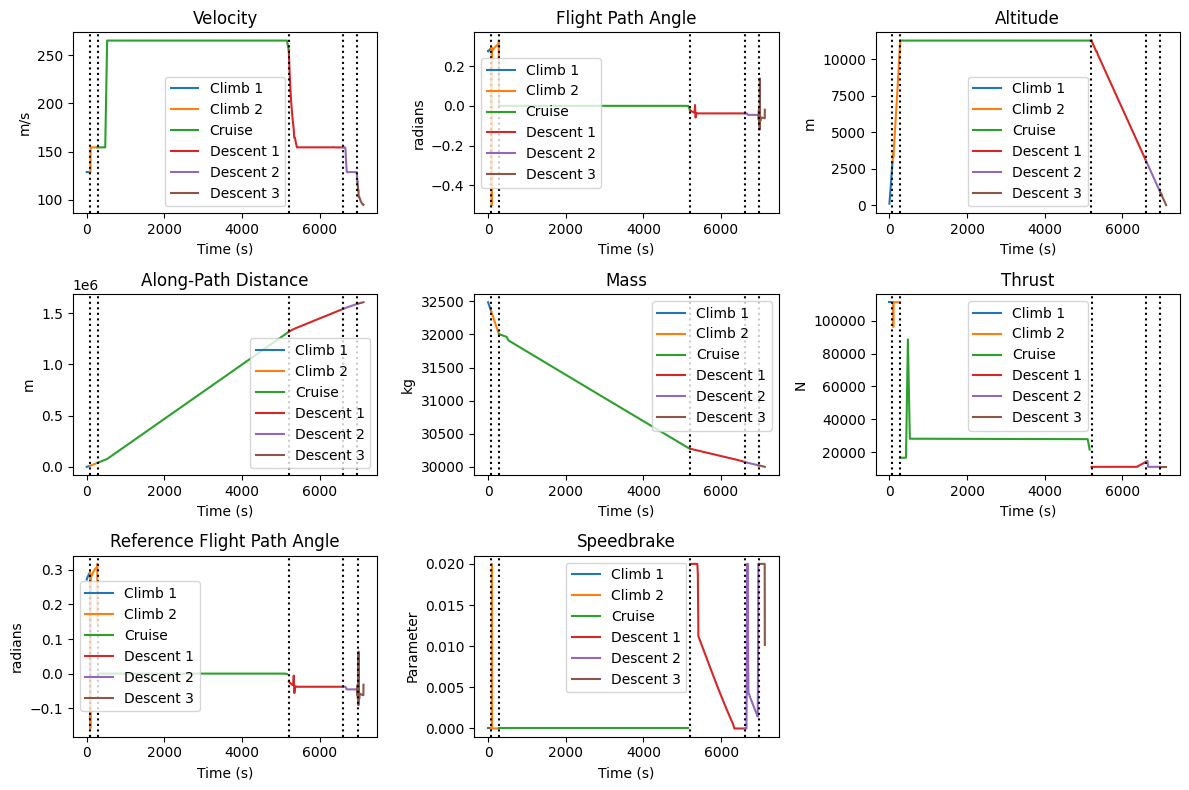

In [13]:
from state_plot import plot_states_with_phases_clb2ds3
plot_states_with_phases_clb2ds3(sol.value(X_list[0]), sol.value(X_list[1]), sol.value(X_list[2]), sol.value(X_list[3]), sol.value(X_list[4]), sol.value(X_list[5]),
                        sol.value(U_list[0]), sol.value(U_list[1]), sol.value(U_list[2]), sol.value(U_list[3]), sol.value(U_list[4]), sol.value(U_list[5]),
                        [sol.value(T_list[i]) for i in range(len(T_list))])


Phase climb1, Duration 79.4471330495483


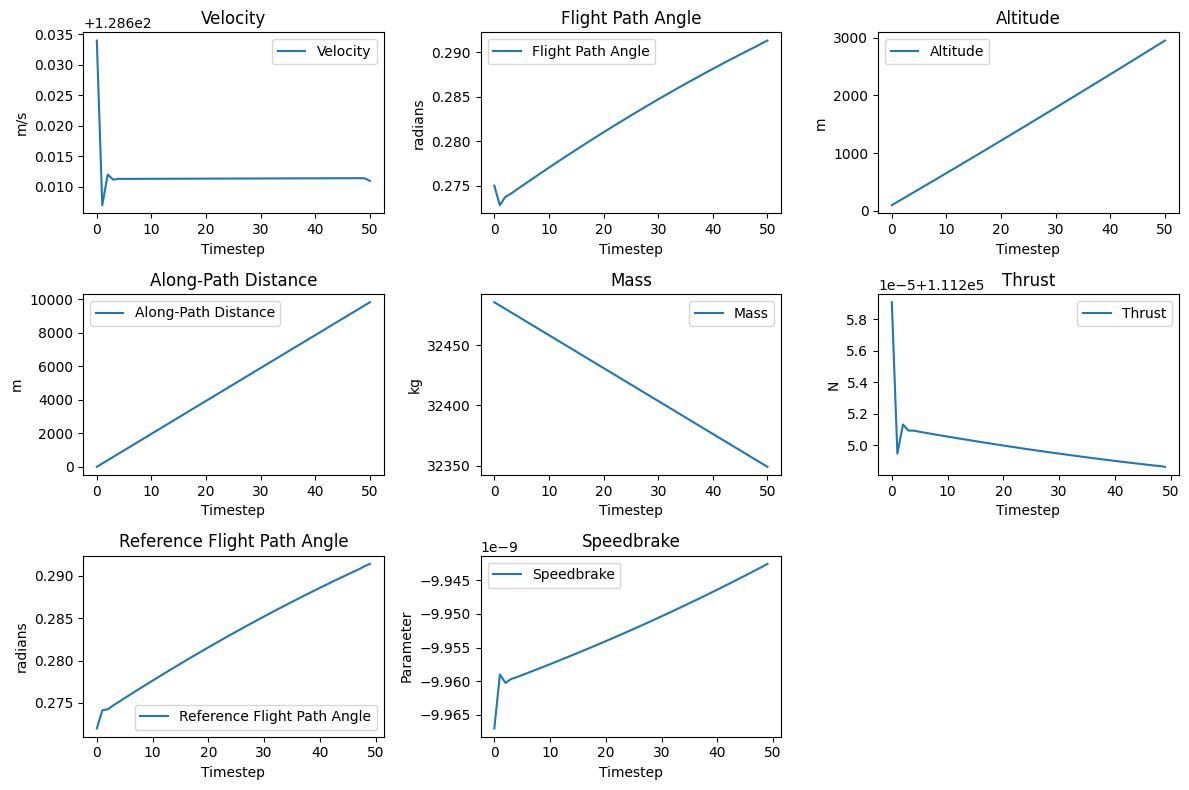

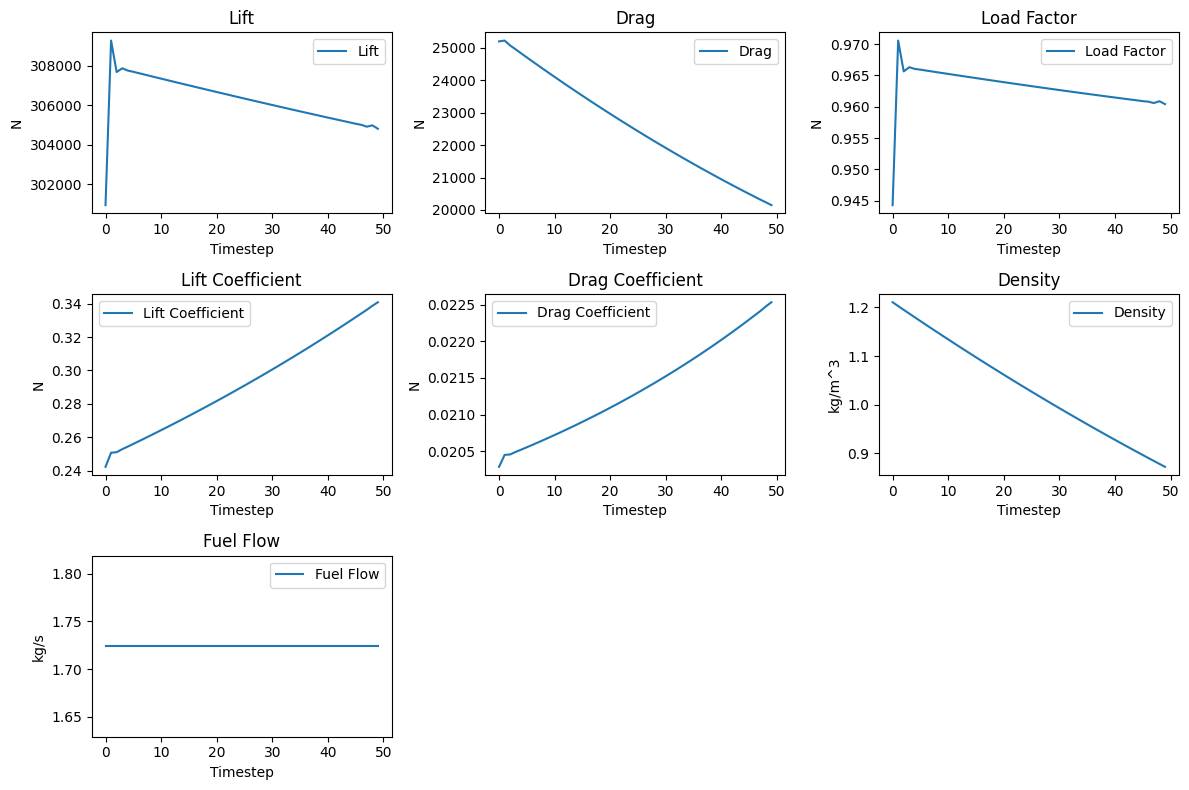

Phase climb2, Duration 199.74648202959122


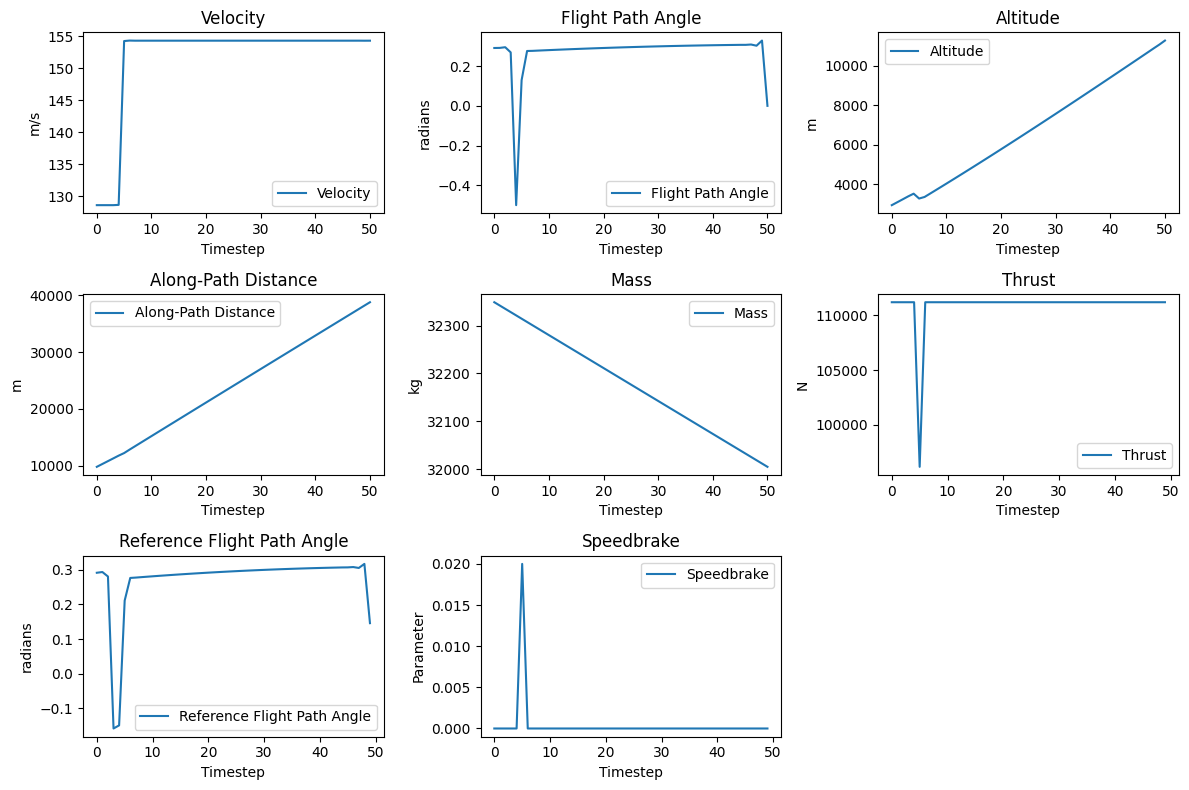

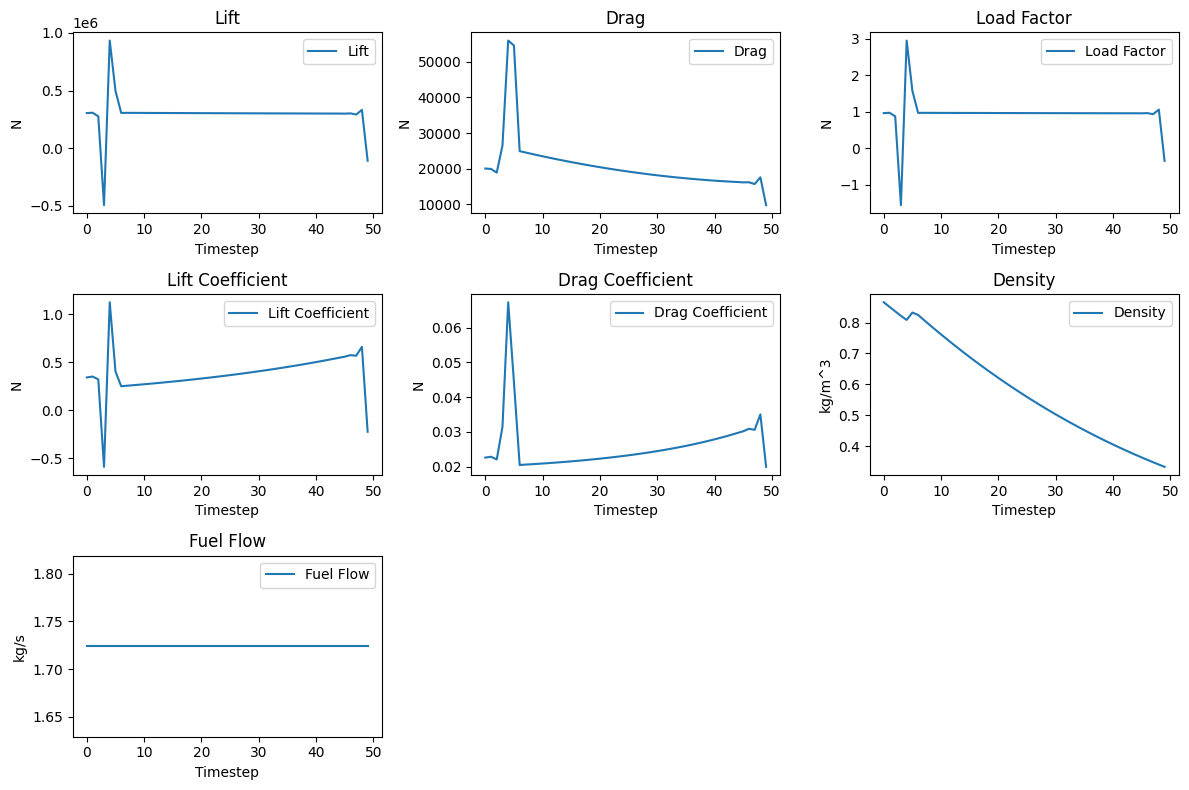

Phase cruise, Duration 4924.8042054433645


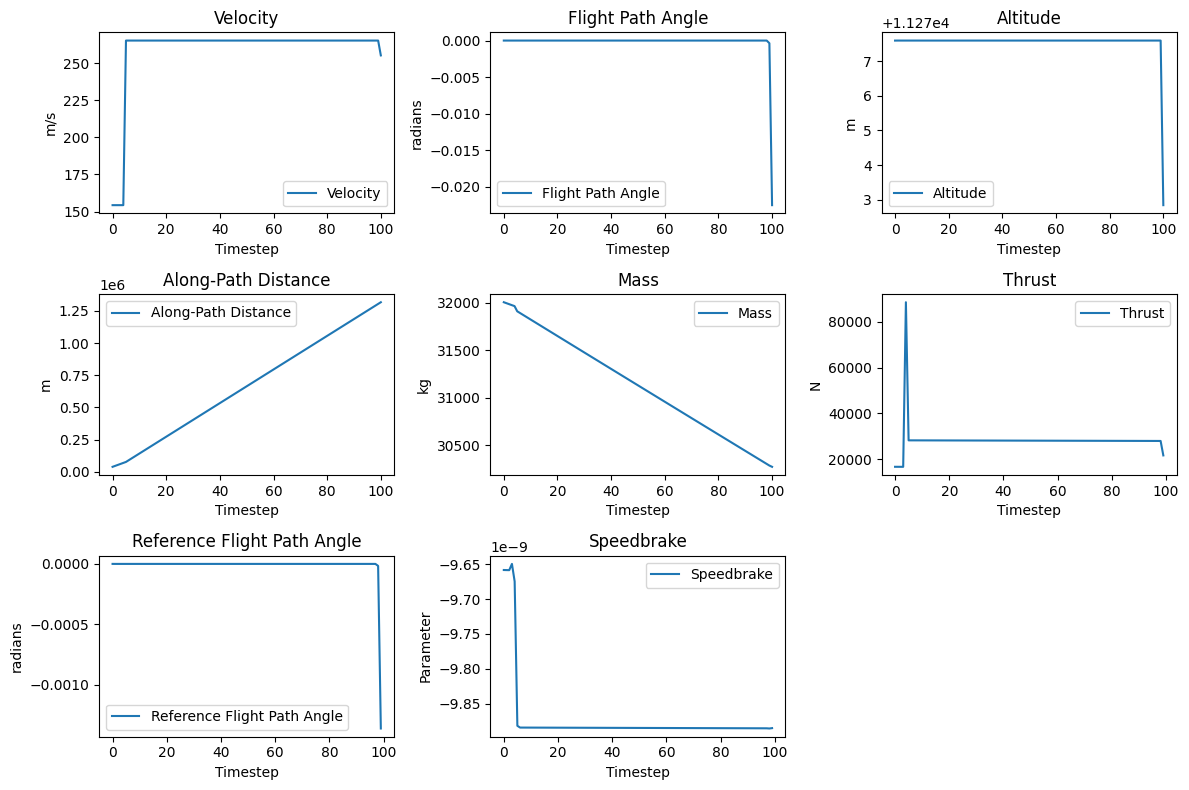

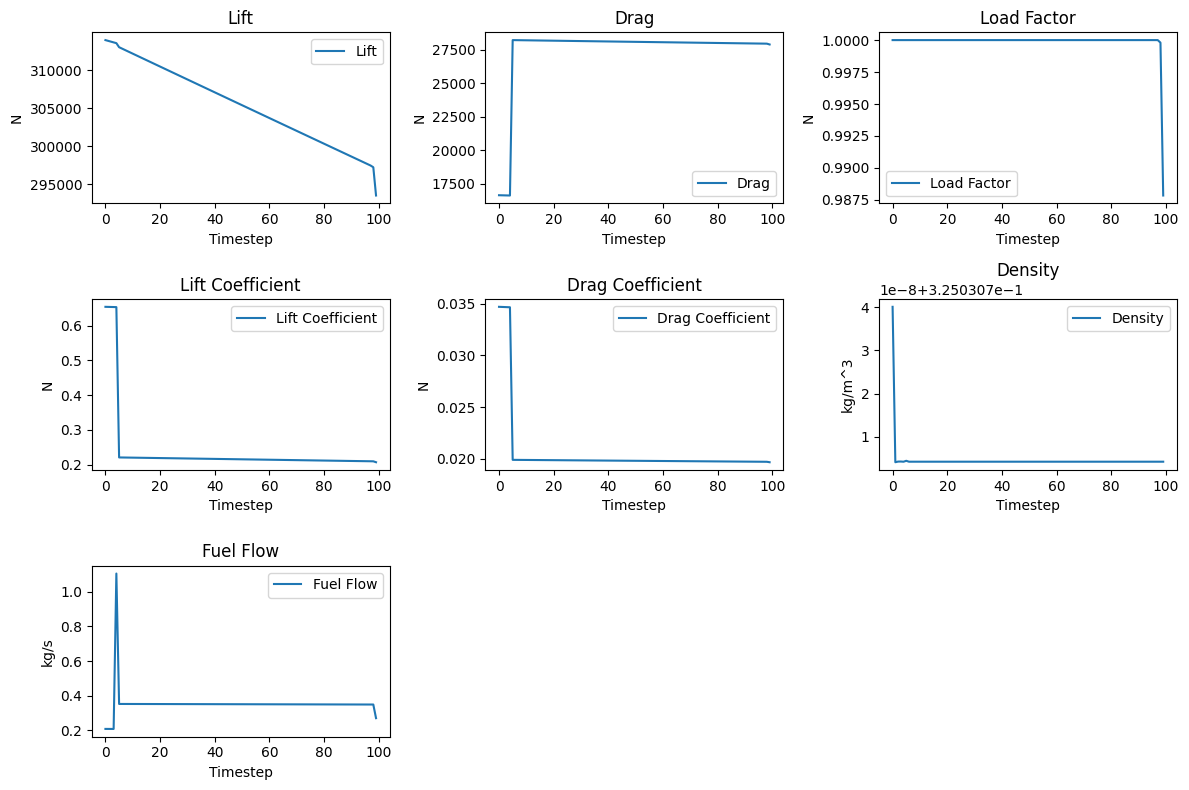

Phase descent1, Duration 1404.000014039999


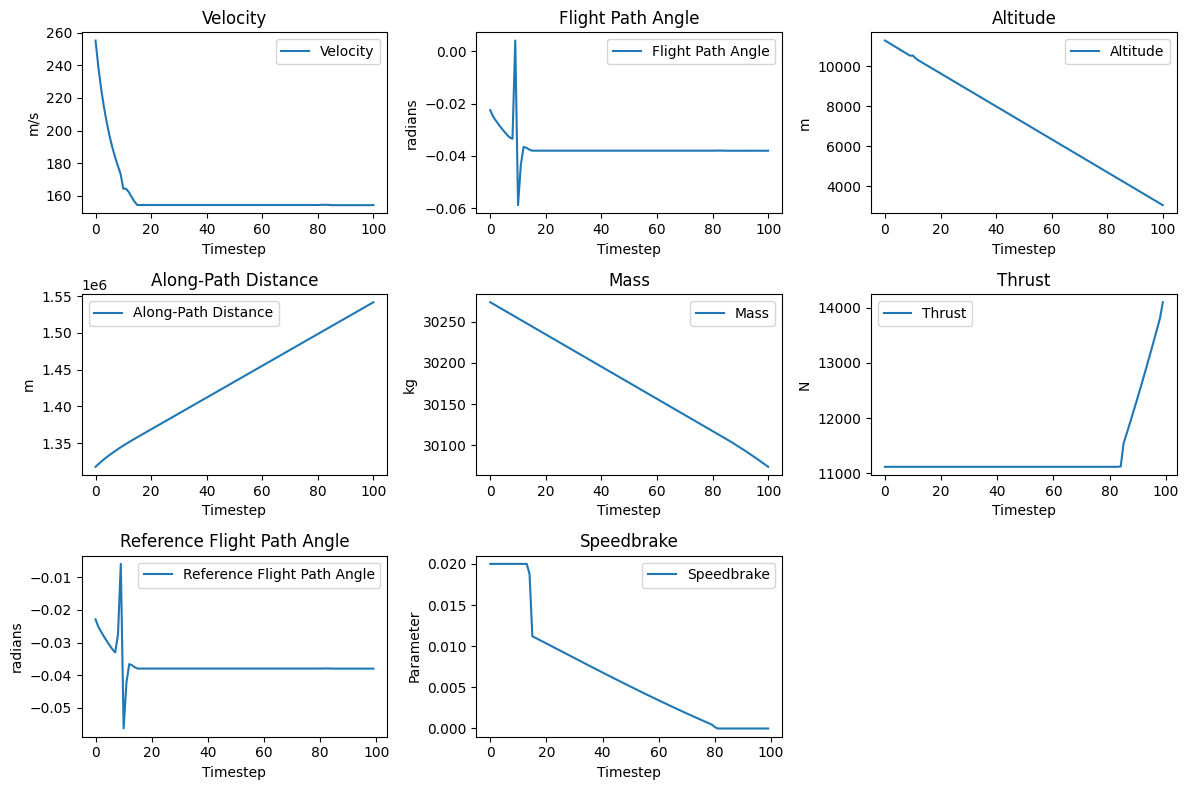

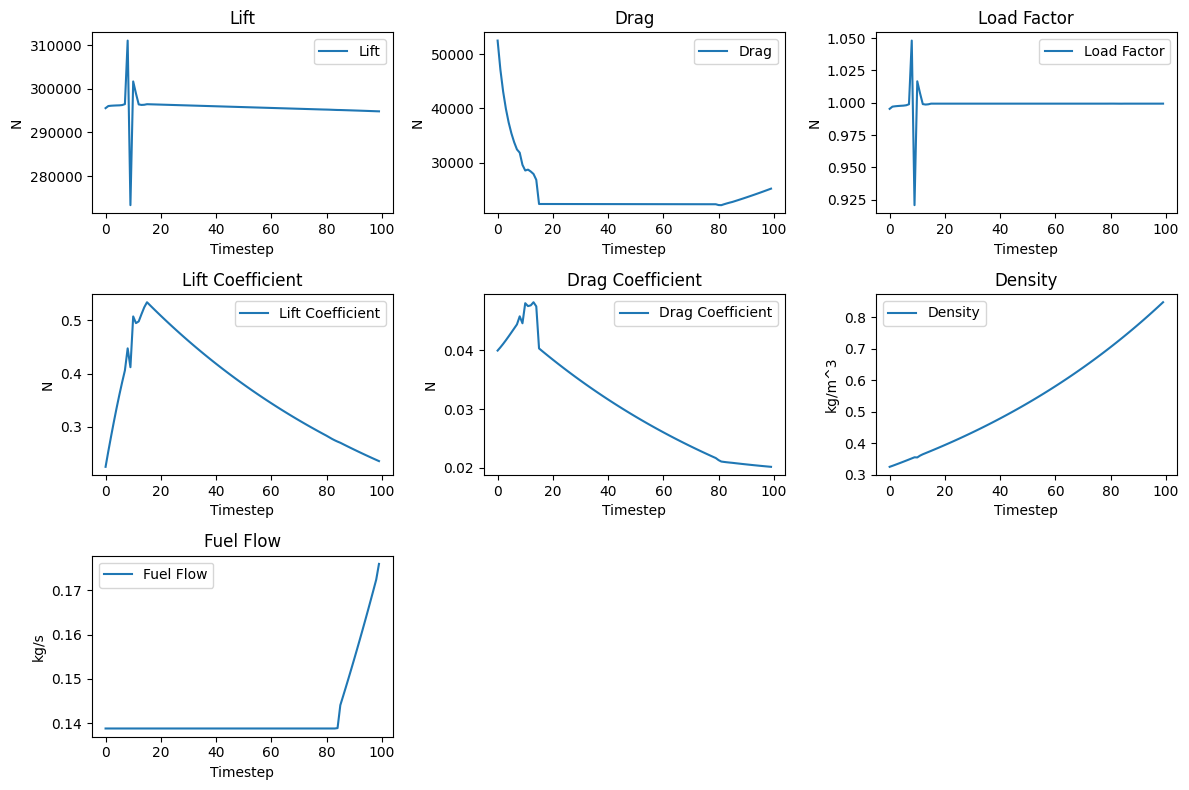

Phase descent2, Duration 364.000003639922


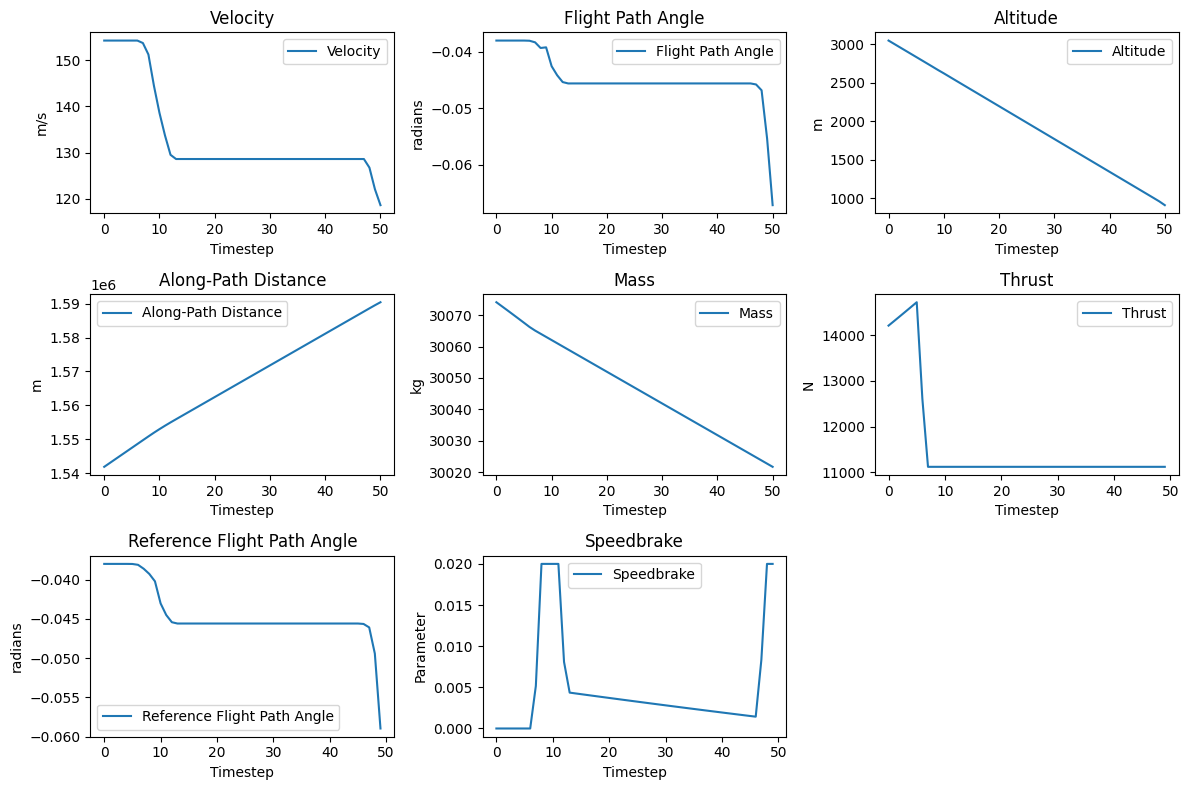

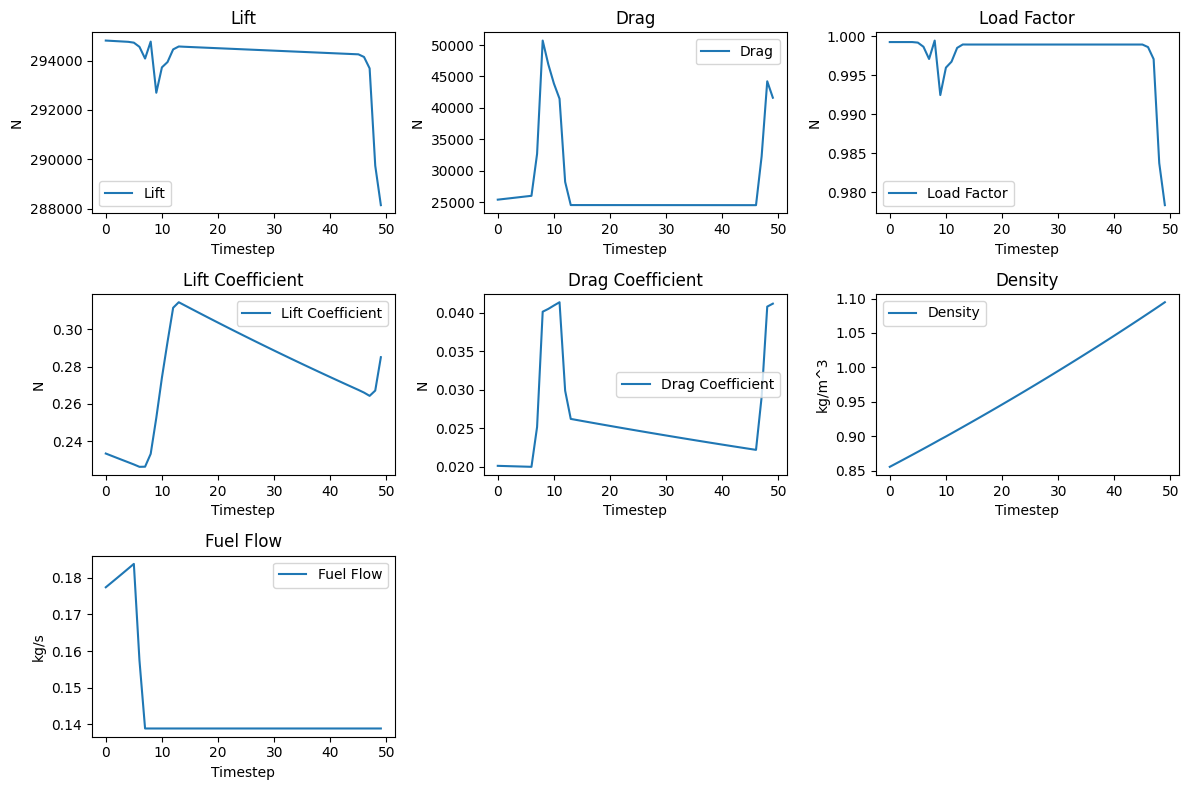

Phase landing, Duration 156.0000015599998


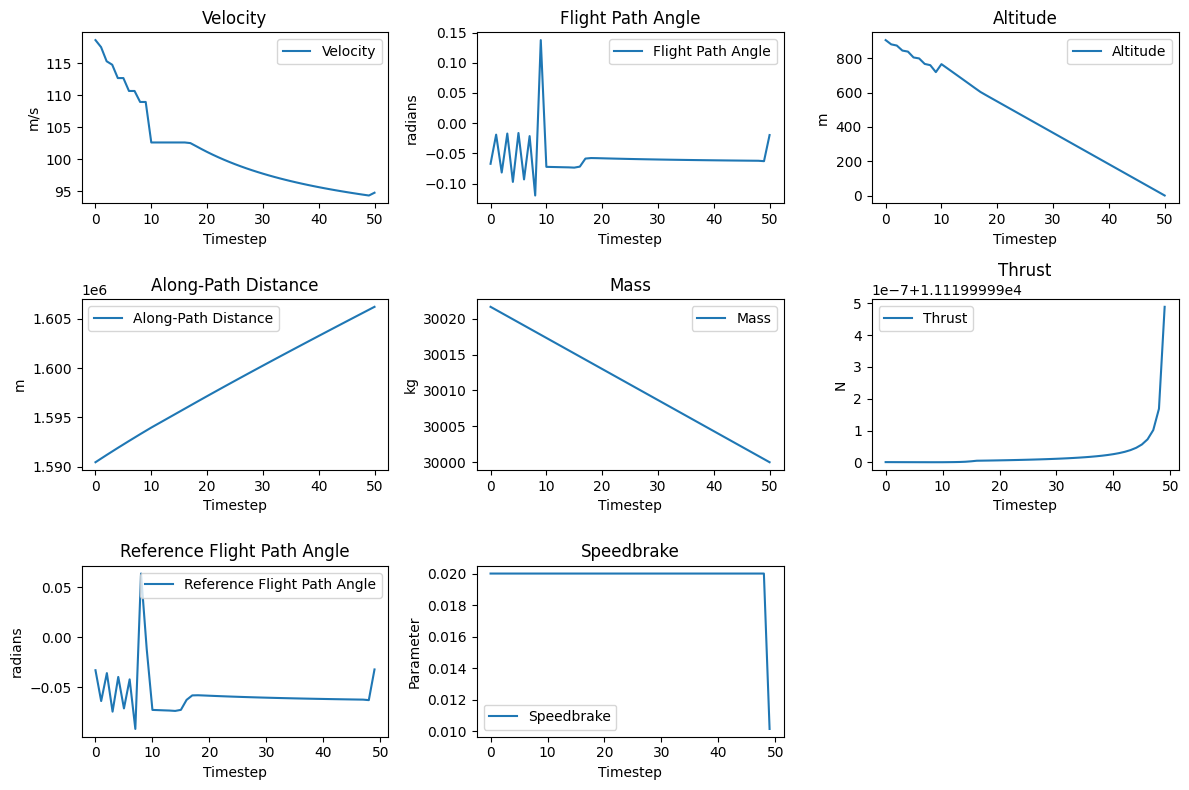

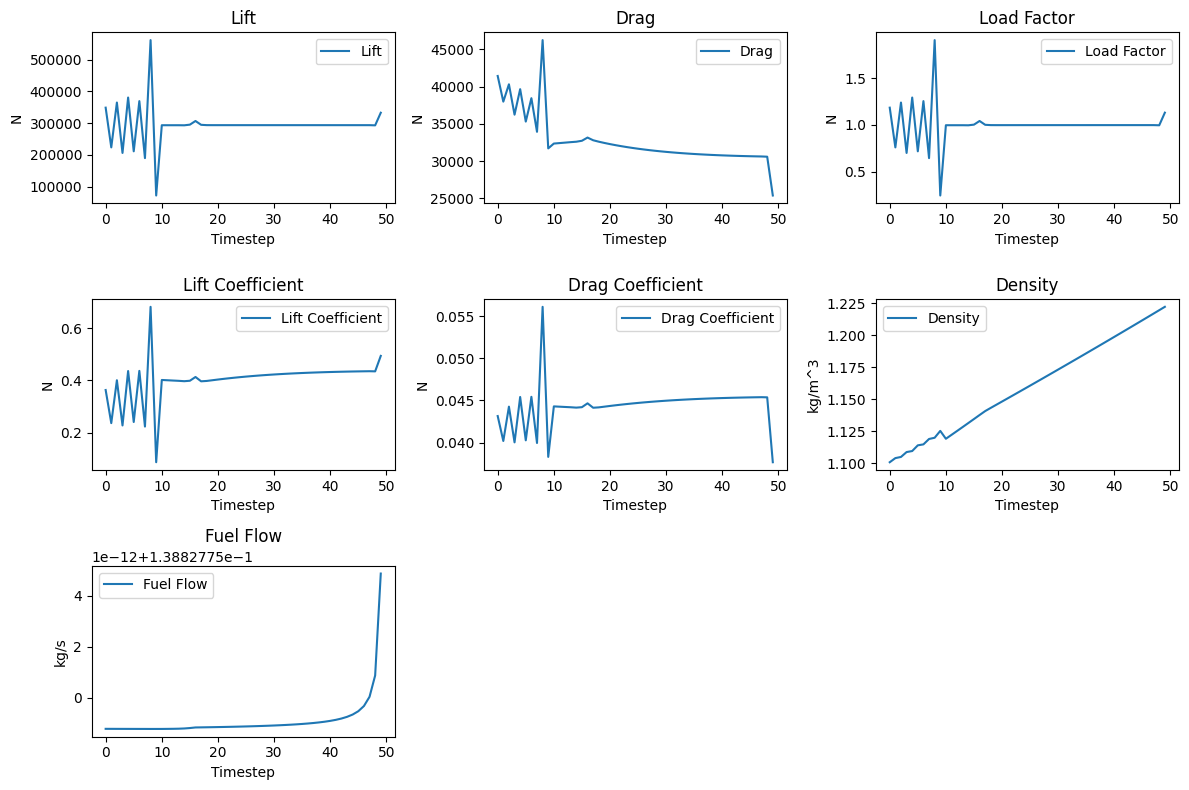

In [14]:
for i, phase in enumerate(phases):
    # print(f"\nPhase: {phase['name']}")
    X_debug = opti.debug.value(X_list[i])
    U_debug = opti.debug.value(U_list[i])
    T_debug = opti.debug.value(T_list[i])

    # print("  States (X) [v, fpa, h, s, m]:")
    # print(X_debug)
    # print("  Controls (U) [thrust, fpa, spdbrk]:")
    # print(U_debug)
    print(f"Phase {phase['name']}, Duration {T_debug}")

    # if "Infeasible_Problem_Detected" in str(e):
        # print("Solver detected infeasibility. Analyzing...")
        # opti.debug.show_infeasibilities()  # Show summary


    # Plot the states
    from state_plot import plot_states, plot_states_ext
    plot_states(X_debug[0], X_debug[1], X_debug[2], X_debug[3], X_debug[4], U_debug[0], U_debug[1], U_debug[2])

    X_ext = np.empty((7, phase['N']))

    # Compute the additional variables
    for k in range(phase['N']):
        xk = X_debug[:,k]
        uk = U_debug[:,k]
        dyn_func = aircraft_dynamics(xk, uk, opti.debug.value(wind_s), opti.debug.value(phi), phase['name'], fiche_engine, fiche_ac, fiche_control)
        dyn_values = opti.debug.value(dyn_func)

        #Further break down
        g = 9.81
        k_gamma = fiche_control['k_gamma']
        v, gamma, h, s, m = xk[0], xk[1], xk[2], xk[3], xk[4]
        T, gamma_ref, beta = uk[0], uk[1], uk[2]
        rho0 = 1.225
        H = 8500.0
        rho = rho0 * np.exp(-h / H)  # Use numpy for scalar calculations during debugging
        nz = (-v * k_gamma * (gamma - gamma_ref) + g * np.cos(gamma))/(g * np.cos(0))
        L = nz * m * g
        epsilon = 1e-6
        v_sq = v**2 + epsilon
        S_area = fiche_ac['wing']['area']
        Cl = L / (0.5 * rho * v_sq * S_area)
        k_drag = fiche_ac['drag']['k']
        Cd = fiche_ac['drag']['cd0'] + beta + k_drag * Cl**2
        D = 0.5 * rho * v**2 * S_area * Cd

        # Fuel flow model (different for each phase)
        if phase['name'] in ['cruise', 'landing', 'descent1', 'descent2']:
            cruise_sfc = fiche_engine['cruise_sfc'] / 3600.0  # [kg/(N·s)]
            fuel_coef = fiche_ac['fuel']['fuel_coef']
            fuel_flow = fuel_coef * cruise_sfc * T
        elif phase['name'] == 'takeoff':
            fuel_flow = fiche_engine['ff_to'] * 2
        elif phase['name'] in ['climb1', 'climb2', 'climb3']:
            fuel_flow = fiche_engine['ff_co'] * 2
        # elif phase['name'] in ['descent1', 'descent2']:
        #     fuel_flow = fiche_engine['ff_app'] * 2
        # elif phase['name'] == 'landing':
        #     fuel_flow = fiche_engine['ff_idl'] * 2
        else:
            fuel_flow = 0.0

        X_ext[:,k] = np.array([L, D, nz, Cl, Cd, rho, fuel_flow])

        if np.isnan(X_ext[:,k]).any():
            print(f"NaN detected at index {k}")
            print(f"X_ext[:,k]: {X_ext[:,k]}")
            print(f"X_ext: {X_ext}")
            print(f"X_ext[0]: {X_ext[0]}")
            print(f"X_ext[1]: {X_ext[1]}")
        
    plot_states_ext(X_ext[0], X_ext[1], X_ext[2], X_ext[3], X_ext[4], X_ext[5], X_ext[6])